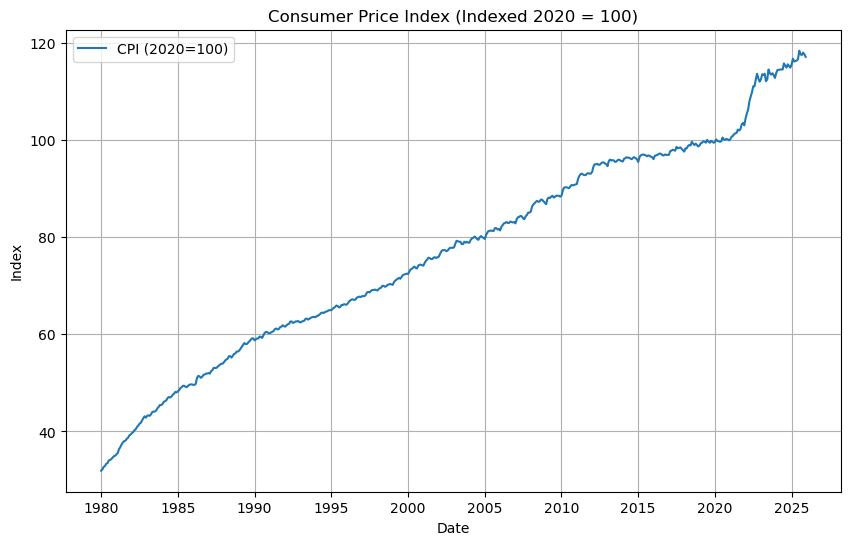

In [12]:
#Subsection 1.1.1
import data as my_data
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load the raw data using the function from your file
raw_data_dict = my_data.load_data()

# 2. Convert the dictionary to a Pandas DataFrame
rows = []
for year, year_data in raw_data_dict.items():
    for month, month_data in year_data['values'].items():
        # Create a row for each month
        rows.append({
            'Date': pd.to_datetime(f"{year}-{month}-01"), # Create a real date object
            'CPI_Raw': month_data['value']
        })

df = pd.DataFrame(rows)

# Sort by date just to be safe
df = df.sort_values('Date')

# 3. Index to 100 on average in 2020
avg_2020 = df[df['Date'].dt.year == 2020]['CPI_Raw'].mean()

# Calculate the new index where 2020 is the baseline (100)
# Formula: (Current_Value / Avg_2020) * 100
df['CPI_2020'] = (df['CPI_Raw'] / avg_2020) * 100

# 4. Plot the result
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['CPI_2020'], label='CPI (2020=100)')
plt.title("Consumer Price Index (Indexed 2020 = 100)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)
plt.show()



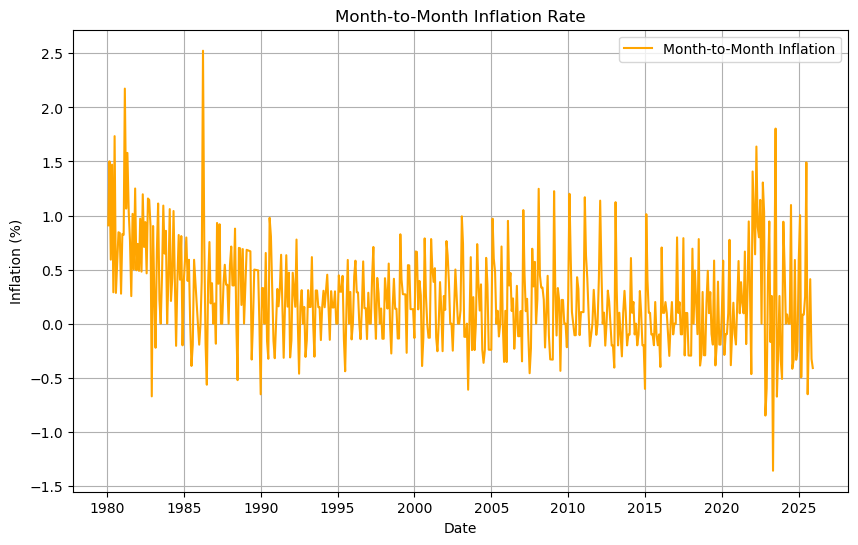

Latest monthly inflation: -0.41084634346754134


In [13]:
#Subsection 1.1.2
df['Inflation_m2m'] = df['CPI_Raw'].pct_change() * 100

# Plotting the month-to-month inflation
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Inflation_m2m'], label='Month-to-Month Inflation', color='orange')

plt.title("Month-to-Month Inflation Rate")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True)
plt.show()

# Checking the latest value to see if it matches expectations
print("Latest monthly inflation:", df['Inflation_m2m'].iloc[-1])

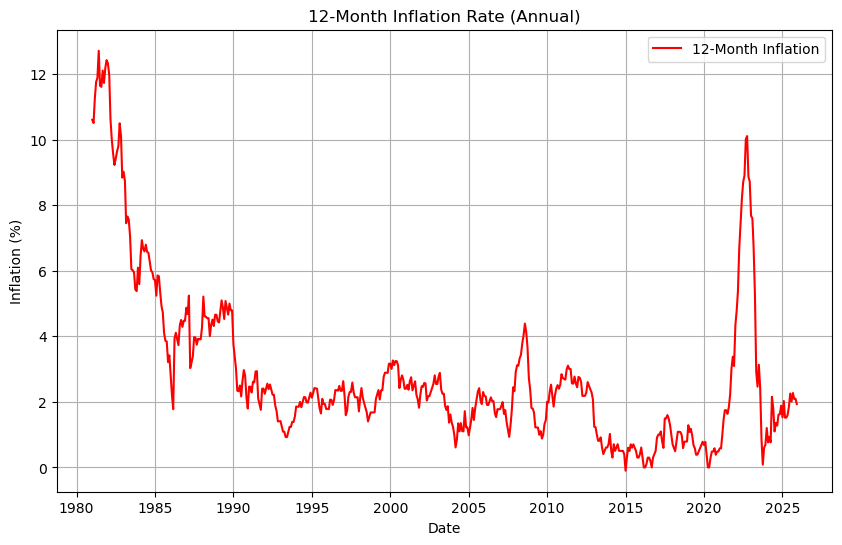

Peak inflation was 12.72% in June 1981.


In [14]:
#Subsection 1.1.3 - The 12-month inflation rate

# Formula: (Pt / Pt-12) - 1
df['Inflation_12m'] = df['CPI_Raw'].pct_change(12) * 100

# Plotting the 12-month inflation
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Inflation_12m'], label='12-Month Inflation', color='red')

plt.title("12-Month Inflation Rate (Annual)")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True)
plt.show()

# Find the peak of the surge
peak_inflation = df.loc[df['Inflation_12m'].idxmax()]
print(f"Peak inflation was {peak_inflation['Inflation_12m']:.2f}% in {peak_inflation['Date'].strftime('%B %Y')}.")

The figure shows that the post-pandemic inflation surge ended in late 2023

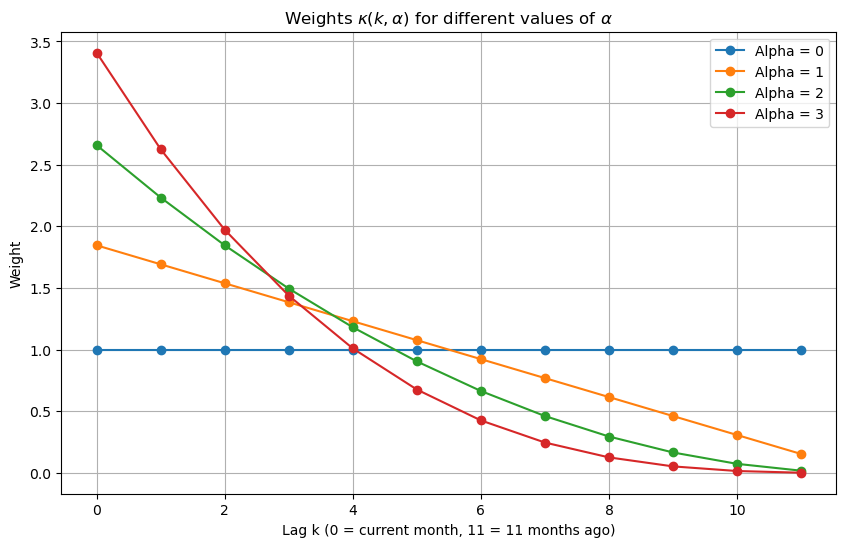

In [15]:
#Subsection 1.2.1
import numpy as np

# 1. Define the weight function kappa
def get_weights(alpha, T=12):
    k = np.arange(0, T)
    
    # Calculate numerator: (T-k)^alpha
    numerator = (T - k) ** alpha
    
    # Calculate denominator: Sum of all numerators
    denominator = np.sum(numerator)
    
    # Calculate kappa
    kappa = (numerator / denominator) * T
    return kappa

# 2. Plot the weights for different alphas
alphas = [0, 1, 2, 3]
plt.figure(figsize=(10, 6))

for alpha in alphas:
    weights = get_weights(alpha)
    plt.plot(np.arange(0, 12), weights, marker='o', label=f'Alpha = {alpha}')

plt.title("Weights $\kappa(k, \\alpha)$ for different values of $\\alpha$")
plt.xlabel("Lag k (0 = current month, 11 = 11 months ago)")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#Subsection 1.2.2 - Instantaneous Inflation Calculation

# 1. Define Weights Function
def get_weights(alpha, T=12):
    k = np.arange(0, T)
    numerator = (T - k) ** alpha
    return (numerator / numerator.sum()) * T

# 2. Define Weighted Inflation Calculator
def calc_weighted_inflation(window, weights):
    aligned_weights = weights[::-1] 
    term = (1 + window/100) ** aligned_weights
    return (np.prod(term) - 1) * 100

# 3. Compute and Update the Main DataFrame
alphas = [0, 1, 2, 3]

for alpha in alphas:
    w = get_weights(alpha)
    col_name = f'Inflation_Instant_{alpha}'
    
    # Update the main df directly
    df[col_name] = df['Inflation_m2m'].rolling(12).apply(
        calc_weighted_inflation, args=(w,), raw=True
    )

# 4. Output the result as a table (showing the new columns)
df[['Date'] + [f'Inflation_Instant_{a}' for a in alphas]].tail(12)

,Date,Inflation_Instant_0,Inflation_Instant_1,Inflation_Instant_2,Inflation_Instant_3
540,2025-01-01,1.528014,1.222540,1.237912,1.380051
541,2025-02-01,2.027027,2.865203,3.687085,4.521928
542,2025-03-01,1.520270,1.609763,1.669876,1.683815
543,2025-04-01,1.518987,1.529927,1.533391,1.491896
544,2025-05-01,1.603376,1.450223,1.416009,1.340665
545,2025-06-01,1.856540,1.668287,1.766901,1.797479
546,2025-07-01,2.253756,4.189758,5.467897,6.529741
547,2025-08-01,2.011735,2.584716,2.673009,2.571972
548,2025-09-01,2.270816,2.115763,1.860797,1.519447
549,2025-10-01,2.090301,2.537455,2.504385,2.420579


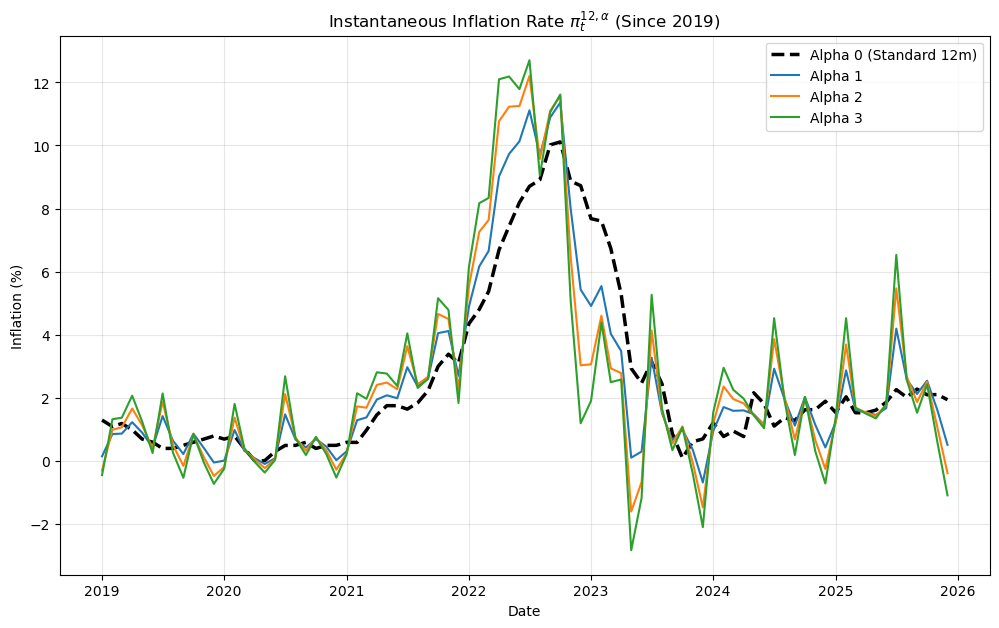

In [17]:
# Subsection 1.2.3 

# 1. Filter for data since 2019
plot_df = df[df['Date'].dt.year >= 2019].copy()

# 2. Create the plot
plt.figure(figsize=(12, 7))

# Plot Alpha 0 (Standard 12m) with a distinct style
plt.plot(plot_df['Date'], plot_df['Inflation_Instant_0'], 
         label='Alpha 0 (Standard 12m)', color='black', linewidth=2.5, linestyle='--')

# Plot the weighted versions (Alpha 1, 2, 3)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green (Hex-codes)
for i, alpha in enumerate([1, 2, 3]):
    plt.plot(plot_df['Date'], plot_df[f'Inflation_Instant_{alpha}'], 
             label=f'Alpha {alpha}', color=colors[i], linewidth=1.5)

# 3. Styling
plt.title(r"Instantaneous Inflation Rate $\pi_t^{12,\alpha}$ (Since 2019)")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Instantaneous inflation shows the surge ended by early 2023, months before the annual rate reached the 2% target. It demonstrates that price momentum had already stabilized while the annual measure remained inflated by the "base effect" of high prices from the previous year.

Fetching data...
 -> Processing CPI Total (000000)...
 -> Processing Excl. Energy (151000)...
 -> Processing Core (Excl. Energy & Food) (141000)...


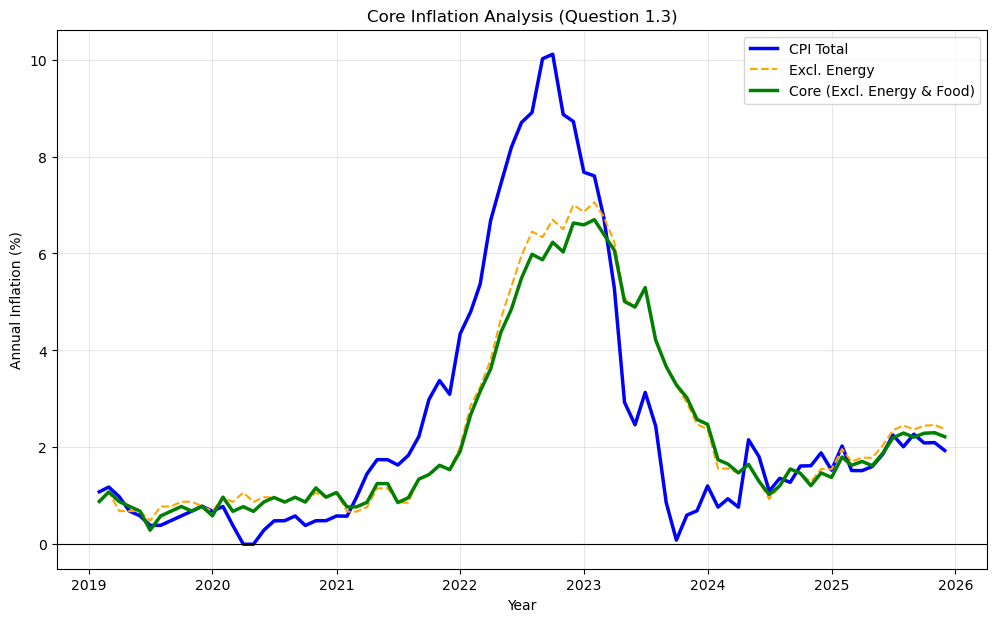

In [18]:
import requests
from io import StringIO

# 1. Define the categories we need to compare
categories = {
    "000000": "CPI Total",
    "151000": "Excl. Energy",
    "141000": "Core (Excl. Energy & Food)"
}

# 2. Function to fetch and clean data for ONE category
def get_inflation_series(group_code):
    """
    Fetches Index data (ENHED=100) and calculates 12-month inflation.
    """
    url = "https://api.statbank.dk/v1/data"
    payload = {
        "table": "PRIS111",
        "format": "CSV",
        "variables": [
            {"code": "VAREGR", "values": [group_code]},
            {"code": "ENHED", "values": ["100"]},
            {"code": "Tid", "values": [">2018M01"]} 
        ]
    }

    # Fetch data
    response = requests.post(url, json=payload)
    
    # Load into Pandas
    df = pd.read_csv(StringIO(response.text), sep=';')
    
    # Create Date column
    df["Date"] = pd.to_datetime(df["TID"], format="%YM%m")
    
    # Clean numeric data (handle commas)
    df["Index"] = pd.to_numeric(df["INDHOLD"].astype(str).str.replace(",", "."), errors='coerce')
    
    # Calculate Inflation (Year-over-Year)
    df = df.sort_values("Date")
    df["Inflation"] = df["Index"].pct_change(12) * 100
    
    # Filter to start from 2019 as requested
    df_clean = df[df["Date"] >= "2019-01-01"].copy()
    
    return df_clean

# 3. Main Loop to Plot All Series
plt.figure(figsize=(12, 7))

print("Fetching data...")

for code, label in categories.items():
    print(f" -> Processing {label} ({code})...")
    
    # Get the data using our simple function
    df = get_inflation_series(code)
    
    # Add line to the plot
    if code == "141000": # Make Core inflation stand out
        plt.plot(df["Date"], df["Inflation"], label=label, linewidth=2.5, color='green')
    elif code == "000000": # Total CPI
        plt.plot(df["Date"], df["Inflation"], label=label, linewidth=2.5, color='blue')
    else: # Excl Energy
        plt.plot(df["Date"], df["Inflation"], label=label, linestyle='--', color='orange')

# 4. Final Styling
plt.title("Core Inflation Analysis (Question 1.3)")
plt.xlabel("Year")
plt.ylabel("Annual Inflation (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=0.8) # Zero line
plt.show()

The right-skewed histogram confirms inflation was broad-based across almost all categories, while the extreme outliers in energy and food staples identify global supply-side shocks as the primary drivers of the surge.

Found 222 categories.
Showing data for: 2025-12-01 00:00:00


/var/folders/_9/6rf5yvw52sg4pt5qm_fy785m0000gn/T/ipykernel_72018/194664383.py:64: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Inflation'] = df.groupby('Category')['Value'].pct_change(12) * 100


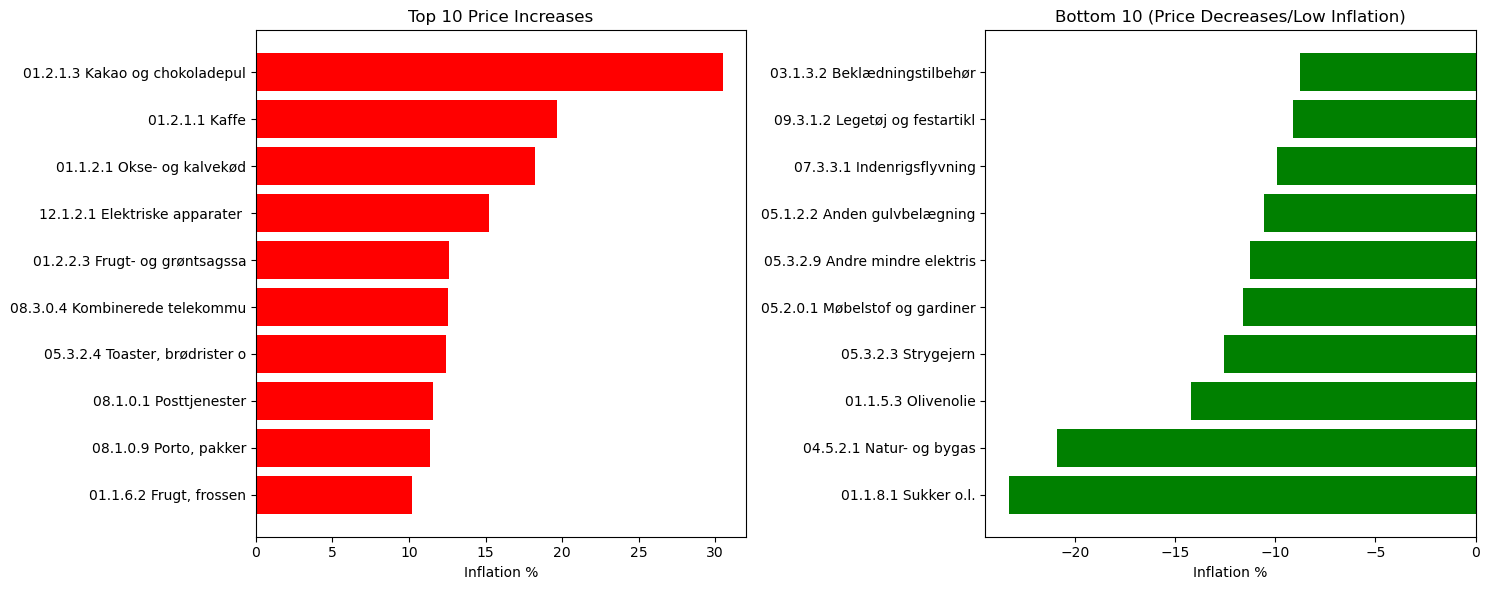

In [19]:
#Subsection 1.4 - Top and Bottom Inflation Categories

def get_product_codes():
    url = "https://api.statbank.dk/v1/tableinfo/PRIS111"
    response = requests.get(url, params={'lang': 'en'})
    
    meta_data = response.json()
    
    # Find the variable group for products ('VAREGR')
    for var in meta_data['variables']:
        if var['id'] == 'VAREGR':
            values = var['values']
            break
    codes = []
    for val in values:
        text = val['text']
        if text.split(' ')[0].count('.') == 3:
            codes.append(val['id'])
            
    print(f"Found {len(codes)} categories.")
    return codes

def get_inflation_data(codes):
    url = "https://api.statbank.dk/v1/data"
    
    payload = {
        "table": "PRIS111",
        "format": "BULK",
        "variables": [
            {"code": "VAREGR", "values": codes},
            {"code": "ENHED", "values": ["100"]}, 
            {"code": "Tid", "values": [">2020M01"]} 
        ]
    }
    response = requests.post(url, json=payload)
    
    # Read the CSV data. 
    csv_data = StringIO(response.content.decode('utf-8-sig'))
    df = pd.read_csv(csv_data, sep=';')
    
    return df

def answer_q1_4():
    # 1. Get the list of codes
    codes = get_product_codes()
    
    # 2. Get the dataframe
    df = get_inflation_data(codes)
    
    # 3. Clean the data
    df.columns = ['Category', 'Unit', 'Time', 'Value']
    
    # Fix the time column (change '2023M01' to a date format)
    df['Date'] = pd.to_datetime(df['Time'].str.replace('M', '-'), format='%Y-%m')
    
    # Fix the value column
    df['Value'] = df['Value'].astype(str).str.replace(',', '.')
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    
    # 4. Calculate inflation
    df = df.sort_values(['Category', 'Date'])
    
    # Calculate the percentage change compared to 12 months ago
    df['Inflation'] = df.groupby('Category')['Value'].pct_change(12) * 100
    
    # 5. Find top and bottom 10 for the latest month
    latest_date = df['Date'].max()
    print(f"Showing data for: {latest_date}")
    
    # Get only the rows for the latest date and remove empty values
    latest_df = df[df['Date'] == latest_date].dropna(subset=['Inflation'])
    
    # Sort by inflation
    latest_df = latest_df.sort_values('Inflation', ascending=False)
    
    top_10 = latest_df.head(10)
    bottom_10 = latest_df.tail(10)
    
    # 6. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot top 10
    ax1.barh(top_10['Category'].str[:30], top_10['Inflation'], color='red')
    ax1.set_title("Top 10 Price Increases")
    ax1.set_xlabel("Inflation %")
    ax1.invert_yaxis() 
    
    # Plot bottom 10
    ax2.barh(bottom_10['Category'].str[:30], bottom_10['Inflation'], color='green')
    ax2.set_title("Bottom 10 (Price Decreases/Low Inflation)")
    ax2.set_xlabel("Inflation %")
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Run the function
answer_q1_4()

Step 1: Fetching Danish CPI from Statbank...


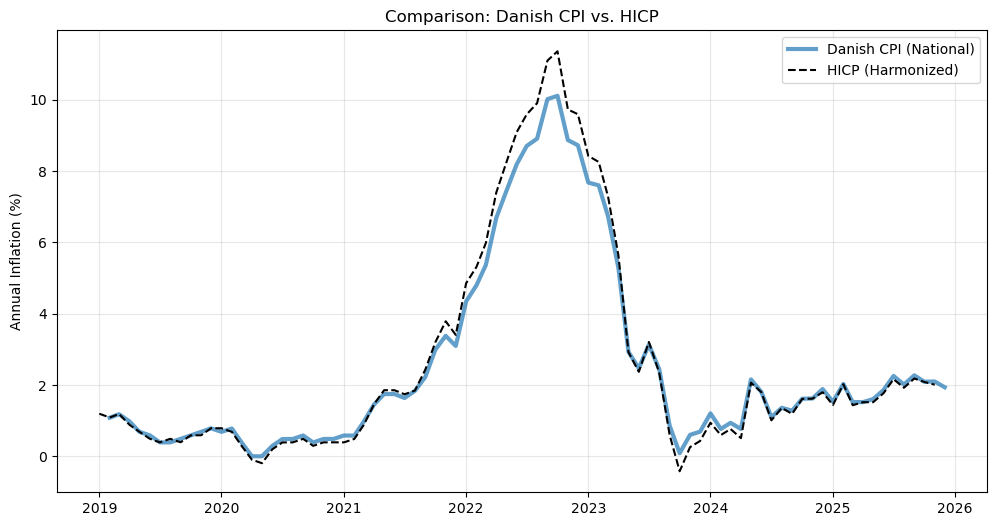

In [20]:
# Subsection 2.1 - Compare Danish CPI with HICP (Fixed)


# Step 1: Get Danish CPI (National Index)
print("Step 1: Fetching Danish CPI from Statbank...")

url = "https://api.statbank.dk/v1/data"
payload = {
    "table": "PRIS113",
    "format": "BULK",
    "variables": [
        {"code": "TYPE", "values": ["*"]},
        {"code": "Tid", "values": [">2018M01"]}
    ]
}

r = requests.post(url, json=payload)

# Check if the request was successful
if r.status_code == 200:
    df_cpi = pd.read_csv(StringIO(r.content.decode('utf-8-sig')), sep=None, engine='python')
    
    if len(df_cpi.columns) >= 3:
        df_cpi = df_cpi.iloc[:, [1, 2]] 
        df_cpi.columns = ['Date', 'Index']
    elif len(df_cpi.columns) == 2:
        df_cpi.columns = ['Date', 'Index']


# Continue only if we have data
if not df_cpi.empty:
    # Clean the data
    df_cpi['Date'] = pd.to_datetime(df_cpi['Date'].astype(str).str.replace('M', '-'), format='%Y-%m')
    
    # Handle the index column (replace comma with dot if needed)
    if df_cpi['Index'].dtype == object:
        df_cpi['Index'] = pd.to_numeric(df_cpi['Index'].str.replace(',', '.'), errors='coerce')

    # Calculate Inflation (Year-over-Year)
    df_cpi = df_cpi.sort_values('Date').set_index('Date')
    df_cpi['CPI_Inflation'] = df_cpi['Index'].pct_change(12) * 100
    
    # Filter for 2019+
    df_cpi_plot = df_cpi[df_cpi.index >= "2019-01-01"]


    # Step 2: Get HICP (Harmonized Index) from FRED
    try:
        # Load API key
        with open('api.txt', 'r') as f:
            api_key = f.read().strip()
        fred = Fred(api_key=api_key)
        
        # Fetch Danish HICP
        hicp_data = fred.get_series('CP0000DKM086NEST')
        
        # Process HICP
        df_hicp = pd.DataFrame({'HICP_Index': hicp_data})
        df_hicp.index.name = 'Date'
        df_hicp['HICP_Inflation'] = df_hicp['HICP_Index'].pct_change(12) * 100
        
        df_hicp_plot = df_hicp[df_hicp.index >= "2019-01-01"]
        

        # Step 3: Plot Comparison
        plt.figure(figsize=(12, 6))
        
        # Plot DST CPI
        plt.plot(df_cpi_plot.index, df_cpi_plot['CPI_Inflation'], 
                 label='Danish CPI (National)', linewidth=3, alpha=0.7)
        
        # Plot FRED HICP
        plt.plot(df_hicp_plot.index, df_hicp_plot['HICP_Inflation'], 
                 label='HICP (Harmonized)', color='black', linestyle='--')
        
        plt.title("Comparison: Danish CPI vs. HICP")
        plt.ylabel("Annual Inflation (%)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        pass

Yes, the two indexes are highly comparable as they show nearly identical trends and levels

Fetching data for all countries...


/var/folders/_9/6rf5yvw52sg4pt5qm_fy785m0000gn/T/ipykernel_72018/2730665225.py:42: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_inflation = df_all.pct_change(12) * 100


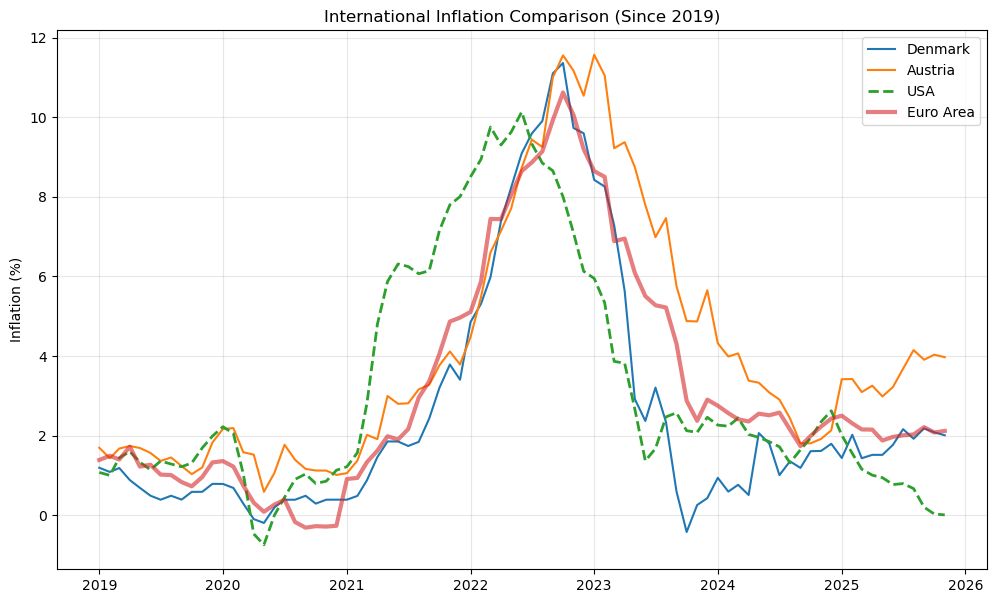


--- Summary Statistics (Min, Max, Mean) by Year ---
     Denmark              Austria                USA              Euro Area  \
         min    max  mean     min    max  mean   min    max  mean       min   
2019    0.39   1.19  0.73    1.03   1.83  1.49  1.00   1.99  1.37      0.73   
2020   -0.19   0.79  0.33    0.59   2.19  1.39 -0.74   2.22  0.77     -0.31   
2021    0.39   3.79  1.94    1.06   4.11  2.76  1.22   8.01  5.33      0.91   
2022    4.85  11.36  8.51    4.48  11.55  8.59  6.13  10.13  8.69      5.11   
2023   -0.42   8.43  3.44    4.87  11.57  7.78  1.37   5.95  3.03      2.37   
2024    0.51   2.06  1.27    1.81   4.32  2.93  1.32   2.62  2.03      1.74   
2025    1.43   2.18  1.82    2.98   4.15  3.56  0.01   2.01  0.83      1.88   

                   
        max  mean  
2019   1.72  1.20  
2020   1.36  0.26  
2021   4.96  2.59  
2022  10.62  8.36  
2023   8.64  5.46  
2024   2.75  2.36  
2025   2.50  2.13  


In [21]:
# Subsection 2.2 - Compare Inflation Across Countries
import pandas as pd
from fredapi import Fred

# 1. Setup - Connect to FRED
# I load the key again just to be safe
try:
    with open('api.txt', 'r') as f:
        api_key = f.read().strip()
    fred = Fred(api_key=api_key)
except:
    print("Error: Could not find api.txt")
    api_key = None

if api_key:
    # 2. Define the countries and their FRED codes
    # Codes are from the assignment text
    countries = {
        "Denmark": "CP0000DKM086NEST",
        "Austria": "CP0000ATM086NEST",
        "USA": "CP0000USM086NEST",
        "Euro Area": "CP0000EZ19M086NEST"
    }

    print("Fetching data for all countries...")
    
    # I will store each series in a dictionary first
    all_data = {}
    for name, code in countries.items():
        try:
            # Get the data
            series = fred.get_series(code)
            all_data[name] = series
        except Exception as e:
            print(f"Could not fetch {name}: {e}")

    # 3. Combine into one DataFrame
    df_all = pd.DataFrame(all_data)
    
    # 4. Calculate 12-month inflation
    # Formula: (Price_t - Price_t-12) / Price_t-12 * 100
    df_inflation = df_all.pct_change(12) * 100
    
    # Filter for data since 2019
    df_inflation = df_inflation[df_inflation.index >= "2019-01-01"]
    
    # 5. Plotting
    plt.figure(figsize=(12, 7))
    
    # Loop through columns to plot each country
    for country in df_inflation.columns:
        # I make the lines slightly different so they are easy to tell apart
        if country == "USA":
            plt.plot(df_inflation.index, df_inflation[country], label=country, linewidth=2, linestyle='--')
        elif country == "Euro Area":
            plt.plot(df_inflation.index, df_inflation[country], label=country, linewidth=3, alpha=0.6)
        else:
            plt.plot(df_inflation.index, df_inflation[country], label=country)
            
    plt.title("International Inflation Comparison (Since 2019)")
    plt.ylabel("Inflation (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 6. Summary Statistics (Min, Max, Mean)
    print("\n--- Summary Statistics (Min, Max, Mean) by Year ---")
    
    # Group by year and calculate stats
    summary = df_inflation.groupby(df_inflation.index.year).agg(['min', 'max', 'mean'])
    
    # Round to 2 decimals to make it look nice
    print(summary.round(2))

The USA experienced the earliest and most aggressive surge, with a mean inflation of 5.33% already in 2021. Denmark and the Euro Area followed a similar trajectory, peaking in 2022 with mean rates around 8.5%, while Austria saw the most persistent inflation, maintaining a high mean of 7.78% into 2023. By 2024 and 2025, Denmark and the USA normalized more rapidly toward the 2% target, whereas Austria’s inflation remained comparatively elevated.

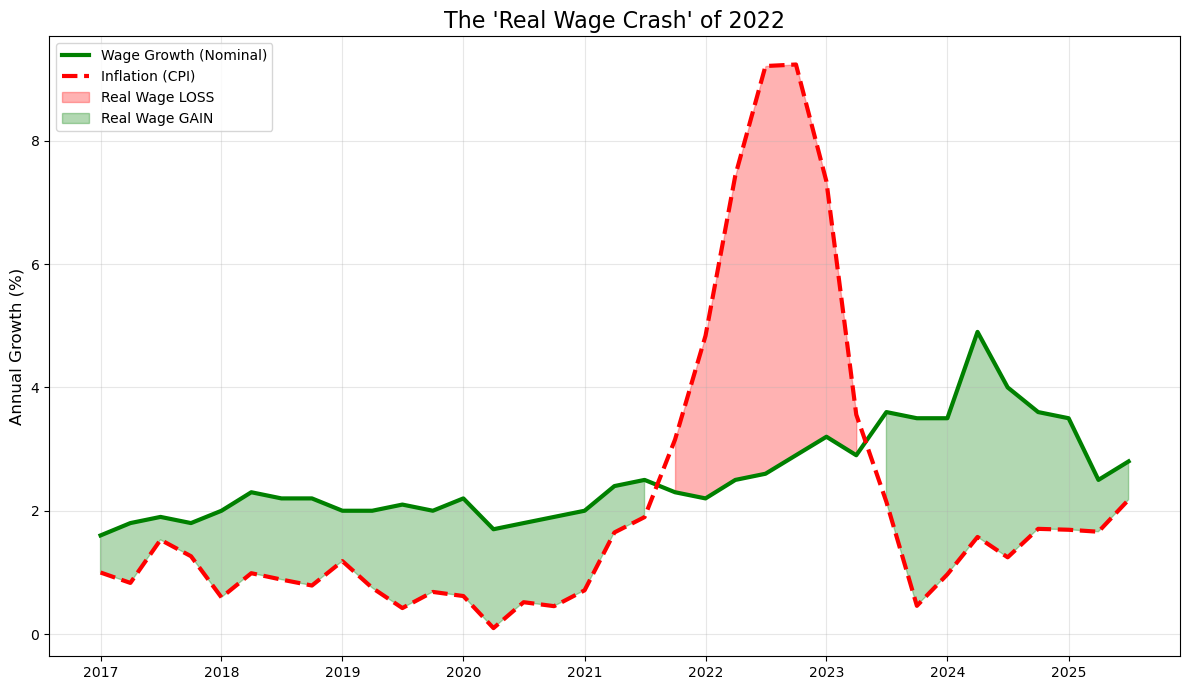

In [22]:
# Subsection 3 - Real Wage Growth vs Inflation

#Objective: This script aims to visualize the recent "Cost of Living Crisis" by 
#comparing the rate of Wage Growth (Income) against the rate of Inflation (Expenses) 
#in the private sector. It calculates the difference between the two to show periods 
#where purchasing power was gained (green) or lost (red).

# 1. Fetch Wage Data (ILON15)
url = "https://api.statbank.dk/v1/data"
payload_wages = {
    "table": "ILON15",
    "format": "BULK",
    "variables": [
        {"code": "ERHVERV", "values": ["TOT"]}, 
        {"code": "Tid", "values": [">2016K1"]}   
    ]
}

r_wages = requests.post(url, json=payload_wages)

# Load and Clean Wages
try:
    df_wages = pd.read_csv(StringIO(r_wages.content.decode('utf-8-sig')), sep=None, engine='python')
except:
    df_wages = pd.read_csv(StringIO(r_wages.content.decode('utf-8-sig')), sep=';')

# Keep Quarter and Index columns
df_wages = df_wages.iloc[:, [1, 2]].copy()
df_wages.columns = ['Quarter', 'Wage_Index']
df_wages['Wage_Index'] = pd.to_numeric(df_wages['Wage_Index'].astype(str).str.replace(',', '.'), errors='coerce')

# Convert Quarters to Date
df_wages['Year'] = df_wages['Quarter'].str[:4]
df_wages['Q'] = df_wages['Quarter'].str[-1].astype(int)
df_wages['Month'] = (df_wages['Q'] * 3) - 2 
df_wages['Date'] = pd.to_datetime(df_wages['Year'] + '-' + df_wages['Month'].astype(str) + '-01')

# Calculate Wage Growth
df_wages = df_wages.sort_values('Date')
if df_wages['Wage_Index'].mean() > 50:
     df_wages['Wage_Growth'] = df_wages['Wage_Index'].pct_change(4) * 100
else:
     df_wages['Wage_Growth'] = df_wages['Wage_Index']

# 2. Fetch Inflation Data (PRIS113)
payload_cpi = {
    "table": "PRIS113",
    "format": "BULK",
    "variables": [
        {"code": "TYPE", "values": ["*"]}, 
        {"code": "Tid", "values": [">2016M01"]} 
    ]
}

r_cpi = requests.post(url, json=payload_cpi)

# Load and Clean CPI
try:
    df_cpi = pd.read_csv(StringIO(r_cpi.content.decode('utf-8-sig')), sep=None, engine='python')
except:
    df_cpi = pd.read_csv(StringIO(r_cpi.content.decode('utf-8-sig')), sep=';')

df_cpi = df_cpi.iloc[:, [-2, -1]].copy()
df_cpi.columns = ['Date', 'CPI_Index']
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'].astype(str).str.replace('M', '-'), format='%Y-%m')
df_cpi['CPI_Index'] = pd.to_numeric(df_cpi['CPI_Index'].astype(str).str.replace(',', '.'), errors='coerce')

# Calculate Inflation and Resample to Quarterly
df_cpi = df_cpi.sort_values('Date')
df_cpi['Inflation'] = df_cpi['CPI_Index'].pct_change(12) * 100
df_cpi_q = df_cpi.set_index('Date').resample('QS')['Inflation'].mean().reset_index()

# 3. Merge and Plot
df_merged = pd.merge(df_wages, df_cpi_q, on='Date', how='inner')
plot_data = df_merged.dropna()

fig, ax = plt.subplots(figsize=(12, 7))

# Plot Lines
ax.plot(plot_data['Date'], plot_data['Wage_Growth'], color='green', linewidth=3, label='Wage Growth (Nominal)')
ax.plot(plot_data['Date'], plot_data['Inflation'], color='red', linewidth=3, linestyle='--', label='Inflation (CPI)')

# Fill Gaps
ax.fill_between(plot_data['Date'], plot_data['Wage_Growth'], plot_data['Inflation'], 
                where=(plot_data['Inflation'] > plot_data['Wage_Growth']), 
                color='red', alpha=0.3, label='Real Wage LOSS')

ax.fill_between(plot_data['Date'], plot_data['Wage_Growth'], plot_data['Inflation'], 
                where=(plot_data['Wage_Growth'] > plot_data['Inflation']), 
                color='green', alpha=0.3, label='Real Wage GAIN')

ax.set_title("The 'Real Wage Crash' of 2022", fontsize=16)
ax.set_ylabel("Annual Growth (%)", fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The figure reveals a severe "Real Wage Crash" starting in 2022. During this period, inflation (red line) surged to nearly 10%, significantly outpacing wage growth (green line), which remained around 3-4%. This resulted in a historic loss of purchasing power for Danish households. A recovery is only observed in late 2023, where wage growth finally overtakes inflation again.